In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



# Sentiment Analysis 

Sentiment analysis is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. Sentiment analysis allows businesses to identify customer sentiment toward products, brands or services in online conversations and feedback.

This notebook uses the data from amazon reviews in mobile phones.

In [2]:
df = pd.read_csv('./input/Amazon_Unlocked_Mobile.csv')
df = df.sample(frac=0.1, random_state=10)
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
394349,Sony XPERIA Z2 D6503 FACTORY UNLOCKED Internat...,NaN,244.95,5,Very good one! Better than Samsung S and iphon...,0.0
34377,Apple iPhone 5c 8GB (Pink) - Verizon Wireless,Apple,194.99,1,"The phone needed a SIM card, would have been n...",1.0
248521,Motorola Droid RAZR MAXX XT912 M Verizon Smart...,Motorola,174.99,5,I was 3 months away from my upgrade and my Str...,3.0
167661,CNPGD [U.S. Office Extended Warranty] Smartwat...,CNPGD,49.99,1,an experience i want to forget,0.0
73287,Apple iPhone 7 Unlocked Phone 256 GB - US Vers...,Apple,922.00,5,GREAT PHONE WORK ACCORDING MY EXPECTATIONS.,1.0


In [3]:
#Drop the missing values.
df.dropna(inplace=True)

#remove any neutral rating equals to 3.
df = df[df['Rating']!=3]

#Encode 4 star and 5 star as positively rated 1.
#Encode 1 star and 2 star as poorely rated 0.
df['Positively Rated'] = np.where(df['Rating']>3,1,0)
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Positively Rated
34377,Apple iPhone 5c 8GB (Pink) - Verizon Wireless,Apple,194.99,1,"The phone needed a SIM card, would have been n...",1.0,0
248521,Motorola Droid RAZR MAXX XT912 M Verizon Smart...,Motorola,174.99,5,I was 3 months away from my upgrade and my Str...,3.0,1
167661,CNPGD [U.S. Office Extended Warranty] Smartwat...,CNPGD,49.99,1,an experience i want to forget,0.0,0
73287,Apple iPhone 7 Unlocked Phone 256 GB - US Vers...,Apple,922.00,5,GREAT PHONE WORK ACCORDING MY EXPECTATIONS.,1.0,1
277158,Nokia N8 Unlocked GSM Touch Screen Phone Featu...,Nokia,95.00,5,I fell in love with this phone because it did ...,0.0,1


[Text(0.5, 1.0, 'Rating vs Review Votes'),
 Text(0.5, 0, 'Rating'),
 Text(0, 0.5, 'Review Votes')]

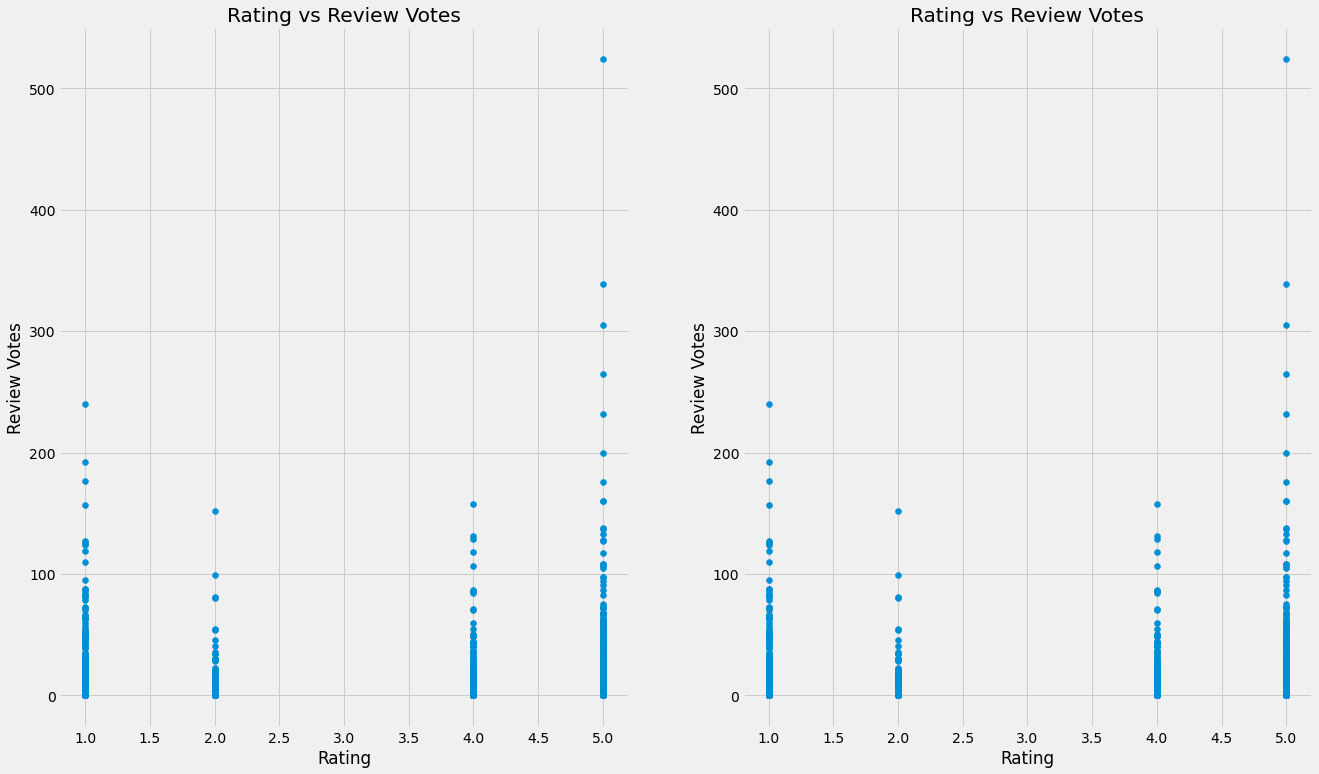

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
fig,(ax0,ax1) = plt.subplots(nrows=1,
                            ncols=2,
                            figsize = (20,12))
ax0.scatter(df['Rating'],df['Review Votes'])
ax0.set(title='Rating vs Review Votes',
       xlabel='Rating',
       ylabel='Review Votes')
ax1.scatter(df['Rating'],df['Review Votes'])
ax1.set(title='Rating vs Review Votes',
       xlabel='Rating',
       ylabel='Review Votes')



In [5]:
# most ratings are positive
df['Positively Rated'].mean()

0.7471776686078667

In [6]:
from sklearn.model_selection import train_test_split

X = df['Reviews']
y = df['Positively Rated']
#spliting data into training and test set.
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)
print('X_train first entry:\n',X_train.iloc[0])
print('\nX_train shape',X_train.shape)

X_train first entry:
 Everything about it is awesome!

X_train shape (23052,)


In [7]:
df['Positively Rated'].value_counts()

1    22966
0     7771
Name: Positively Rated, dtype: int64

# Count Vectorizer

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
#fit the countVectorizer to the training data.
vect = CountVectorizer()
vect.fit(X_train)

#getting every 2000 vocabulay features.
vect.get_feature_names()[::2000]

['00',
 'arroja',
 'comapañias',
 'dvds',
 'golden',
 'lands',
 'oil',
 'razonable',
 'smallsliver',
 'tweak']

In [9]:
len(vect.get_feature_names())

19601

In [10]:
#transform the document in the training data to a document term matrix.
X_train_vectorized = vect.transform(X_train)
X_train_vectorized

<23052x19601 sparse matrix of type '<class 'numpy.int64'>'
	with 613289 stored elements in Compressed Sparse Row format>

In [11]:
from sklearn.linear_model import LogisticRegression
#train the model.
model = LogisticRegression()
model.fit(X_train_vectorized,y_train)

C:\Users\aditi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [12]:
from sklearn.metrics import roc_auc_score,roc_curve

#predict the transform test document.
predictions = model.predict(vect.transform(X_test))
print('AUC: ',roc_auc_score(y_test,predictions))

AUC:  0.8964855428049677


In [13]:
#get the feature names as numpy array.
feature_names = np.array(vect.get_feature_names())

#sort the coffecient from the model.
sorted_coef_index = model.coef_[0].argsort()

'''Find the 10 smallest and 10 largest coefficients.
 The 10 largest coefficients are being indexed using [:-11:-1] 
 so the list returned is in order of largest to smallest.'''

print('Smallest Coefficient(Negative reviews): \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coeffiecient(Positive reviews): \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefficient(Negative reviews): 
['worst' 'terrible' 'slow' 'junk' 'sucks' 'waste' 'poor' 'disappointed'
 'broke' 'useless']

Largest Coeffiecient(Positive reviews): 
['excelent' 'excellent' 'excelente' 'perfectly' 'love' 'perfect' 'exactly'
 'great' 'best' 'awesome']


## SVC

In [26]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
model1 =  SVC(kernel ='linear', random_state=0)
model1.fit(X_train_vectorized,y_train)
predictions = model1.predict(vect.transform(X_test))
print('AUC: ',roc_auc_score(y_test,predictions))

AUC:  0.9087001475723238


## RANDOM FOREST

In [27]:
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(n_estimators=300, max_features="auto")
model2.fit(X_train_vectorized,y_train)
predictions = model2.predict(vect.transform(X_test))
print('AUC: ',roc_auc_score(y_test,predictions))

AUC:  0.8805774927383048


##  TFIDF(Term Frequency-Inverse Document Frequency)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
vect = TfidfVectorizer(min_df=5).fit(X_train)
len(vect.get_feature_names())

5442

In [15]:
X_train_vectorized = vect.transform(X_train)

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.889951006492175


In [16]:
feature_names = np.array(vect.get_feature_names())

sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['61' 'printer' 'approach' 'adjustment' 'consequences' 'length' 'emailing'
 'degrees' 'handsfree' 'chipset']

Largest tfidf: 
['unlocked' 'handy' 'useless' 'cheat' 'up' 'original' 'exelent' 'exelente'
 'exellent' 'satisfied']


In [17]:
sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['not' 'slow' 'disappointed' 'worst' 'terrible' 'never' 'return' 'doesn'
 'horrible' 'waste']

Largest Coefs: 
['great' 'love' 'excellent' 'good' 'best' 'perfect' 'price' 'awesome'
 'far' 'perfectly']


In [18]:
# These reviews are treated the same by our current model
print(model.predict(vect.transform(['not an issue, phone is working',
                                    'an issue, phone is not working'])))

[0 0]


# n-grams

In [19]:
# Fit the CountVectorizer to the training data specifiying a minimum 
# document frequency of 5 and extracting 1-grams and 2-grams
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X_train)

X_train_vectorized = vect.transform(X_train)

len(vect.get_feature_names())

29072

In [20]:
import pickle
pickle.dump(vect, open("vect.pickle", "wb"))

In [21]:
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions))

C:\Users\aditi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC:  0.9104640361714084


In [22]:
feature_names = np.array(vect.get_feature_names())

sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['no good' 'junk' 'poor' 'slow' 'worst' 'broken' 'not good' 'terrible'
 'defective' 'horrible']

Largest Coefs: 
['excellent' 'excelente' 'perfect' 'excelent' 'great' 'love' 'awesome'
 'no problems' 'good' 'best']


# Examples

In [23]:
# These reviews are now correctly identified
print(model.predict(vect.transform(['not an issue, phone is working',
                                    'an issue, phone is not working'])))

[1 0]


In [24]:
import pickle
pickle.dump(model, open("vectorizer.pickle", "wb"))

In [28]:
# These reviews are now correctly identified
print(model.predict(vect.transform(['not a good phone'])))

[0]


In [29]:
# These reviews are now correctly identified
print(model.predict(vect.transform(['gkjsdkjfhskj'])))

[1]


In [30]:
# These reviews are now correctly identified
print(model.predict(vect.transform(['@er'])))

[1]


In [39]:
# These reviews are now correctly identified
print(model.predict(vect.transform(['''It's a value for money product.. But if you r a photography Anthusiast then this phone is definitely not for you.. Pubg works fine so you can play games no doubt. Battery is awesome. I deducted 1star only because in this price segment we might find better phones from realme.'''])))

[1]


https://www.flipkart.com/poco-m3-power-black-64-gb/product-reviews/itmb49cc10841be2?pid=MOBFZTCUTAYPJHHR&lid=LSTMOBFZTCUTAYPJHHR2ZVC1N&marketplace=FLIPKART&page=3